In [9]:

# Install extra-dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Please use Py365 ENV

In [10]:
from __future__ import absolute_import
from __future__ import division

import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.layers import Layer
from keras.layers import InputSpec

from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_marginal_accuracy
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.utils.test_utils import to_tuple


class CRF(Layer):
    """An implementation of linear chain conditional random field (CRF).
    An linear chain CRF is defined to maximize the following likelihood function:
    $$ L(W, U, b; y_1, ..., y_n) := \frac{1}{Z}
    \sum_{y_1, ..., y_n} \exp(-a_1' y_1 - a_n' y_n
        - \sum_{k=1^n}((f(x_k' W + b) y_k) + y_1' U y_2)), $$
    where:
        $Z$: normalization constant
        $x_k, y_k$:  inputs and outputs
    This implementation has two modes for optimization:
    1. (`join mode`) optimized by maximizing join likelihood,
    which is optimal in theory of statistics.
       Note that in this case, CRF must be the output/last layer.
    2. (`marginal mode`) return marginal probabilities on each time
    step and optimized via composition
       likelihood (product of marginal likelihood), i.e.,
       using `categorical_crossentropy` loss.
       Note that in this case, CRF can be either the last layer or an
       intermediate layer (though not explored).
    For prediction (test phrase), one can choose either Viterbi
    best path (class indices) or marginal
    probabilities if probabilities are needed.
    However, if one chooses *join mode* for training,
    Viterbi output is typically better than marginal output,
    but the marginal output will still perform
    reasonably close, while if *marginal mode* is used for training,
    marginal output usually performs
    much better. The default behavior and `metrics.crf_accuracy`
    is set according to this observation.
    In addition, this implementation supports masking and accepts either
    onehot or sparse target.
    If you open a issue or a pull request about CRF, please
    add 'cc @lzfelix' to notify Luiz Felix.
    # Examples
    ```python
        from keras_contrib.layers import CRF
        from keras_contrib.losses import crf_loss
        from keras_contrib.metrics import crf_viterbi_accuracy
        model = Sequential()
        model.add(Embedding(3001, 300, mask_zero=True)(X)
        # use learn_mode = 'join', test_mode = 'viterbi',
        # sparse_target = True (label indice output)
        crf = CRF(10, sparse_target=True)
        model.add(crf)
        # crf_accuracy is default to Viterbi acc if using join-mode (default).
        # One can add crf.marginal_acc if interested, but may slow down learning
        model.compile('adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
        # y must be label indices (with shape 1 at dim 3) here,
        # since `sparse_target=True`
        model.fit(x, y)
        # prediction give onehot representation of Viterbi best path
        y_hat = model.predict(x_test)
    ```
    The following snippet shows how to load a persisted
    model that uses the CRF layer:
    ```python
        from keras.models import load_model
        from keras_contrib.losses import import crf_loss
        from keras_contrib.metrics import crf_viterbi_accuracy
        custom_objects={'CRF': CRF,
                        'crf_loss': crf_loss,
                        'crf_viterbi_accuracy': crf_viterbi_accuracy}
        loaded_model = load_model('<path_to_model>',
                                  custom_objects=custom_objects)
    ```
    # Arguments
        units: Positive integer, dimensionality of the output space.
        learn_mode: Either 'join' or 'marginal'.
            The former train the model by maximizing join likelihood while the latter
            maximize the product of marginal likelihood over all time steps.
            One should use `losses.crf_nll` for 'join' mode
            and `losses.categorical_crossentropy` or
            `losses.sparse_categorical_crossentropy` for
            `marginal` mode.  For convenience, simply
            use `losses.crf_loss`, which will decide the proper loss as described.
        test_mode: Either 'viterbi' or 'marginal'.
            The former is recommended and as default when `learn_mode = 'join'` and
            gives one-hot representation of the best path at test (prediction) time,
            while the latter is recommended and chosen as default
            when `learn_mode = 'marginal'`,
            which produces marginal probabilities for each time step.
            For evaluating metrics, one should
            use `metrics.crf_viterbi_accuracy` for 'viterbi' mode and
            'metrics.crf_marginal_accuracy' for 'marginal' mode, or
            simply use `metrics.crf_accuracy` for
            both which automatically decides it as described.
            One can also use both for evaluation at training.
        sparse_target: Boolean (default False) indicating
            if provided labels are one-hot or
            indices (with shape 1 at dim 3).
        use_boundary: Boolean (default True) indicating if trainable
            start-end chain energies
            should be added to model.
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        chain_initializer: Initializer for the `chain_kernel` weights matrix,
            used for the CRF chain energy.
            (see [initializers](../initializers.md)).
        boundary_initializer: Initializer for the `left_boundary`,
            'right_boundary' weights vectors,
            used for the start/left and end/right boundary energy.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        chain_regularizer: Regularizer function applied to
            the `chain_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        boundary_regularizer: Regularizer function applied to
            the 'left_boundary', 'right_boundary' weight vectors
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        chain_constraint: Constraint function applied to
            the `chain_kernel` weights matrix
            (see [constraints](../constraints.md)).
        boundary_constraint: Constraint function applied to
            the `left_boundary`, `right_boundary` weights vectors
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        unroll: Boolean (default False). If True, the network will be
            unrolled, else a symbolic loop will be used.
            Unrolling can speed-up a RNN, although it tends
            to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    # Input shape
        3D tensor with shape `(nb_samples, timesteps, input_dim)`.
    # Output shape
        3D tensor with shape `(nb_samples, timesteps, units)`.
    # Masking
        This layer supports masking for input data with a variable number
        of timesteps. To introduce masks to your data,
        use an [Embedding](embeddings.md) layer with the `mask_zero` parameter
        set to `True`.
    """

    def __init__(self, units,
                 learn_mode='join',
                 test_mode=None,
                 sparse_target=False,
                 use_boundary=True,
                 use_bias=True,
                 activation='linear',
                 kernel_initializer='glorot_uniform',
                 chain_initializer='orthogonal',
                 bias_initializer='zeros',
                 boundary_initializer='zeros',
                 kernel_regularizer=None,
                 chain_regularizer=None,
                 boundary_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 chain_constraint=None,
                 boundary_constraint=None,
                 bias_constraint=None,
                 input_dim=None,
                 unroll=False,
                 **kwargs):
        super(CRF, self).__init__(**kwargs)
        self.supports_masking = True
        self.units = units
        self.learn_mode = learn_mode
        assert self.learn_mode in ['join', 'marginal']
        self.test_mode = test_mode
        if self.test_mode is None:
            self.test_mode = 'viterbi' if self.learn_mode == 'join' else 'marginal'
        else:
            assert self.test_mode in ['viterbi', 'marginal']
        self.sparse_target = sparse_target
        self.use_boundary = use_boundary
        self.use_bias = use_bias

        self.activation = activations.get(activation)

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.chain_initializer = initializers.get(chain_initializer)
        self.boundary_initializer = initializers.get(boundary_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.chain_regularizer = regularizers.get(chain_regularizer)
        self.boundary_regularizer = regularizers.get(boundary_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.chain_constraint = constraints.get(chain_constraint)
        self.boundary_constraint = constraints.get(boundary_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.unroll = unroll

    def build(self, input_shape):
        input_shape = to_tuple(input_shape)
        self.input_spec = [InputSpec(shape=input_shape)]
        self.input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(self.input_dim, self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.chain_kernel = self.add_weight(shape=(self.units, self.units),
                                            name='chain_kernel',
                                            initializer=self.chain_initializer,
                                            regularizer=self.chain_regularizer,
                                            constraint=self.chain_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = 0

        if self.use_boundary:
            self.left_boundary = self.add_weight(shape=(self.units,),
                                                 name='left_boundary',
                                                 initializer=self.boundary_initializer,
                                                 regularizer=self.boundary_regularizer,
                                                 constraint=self.boundary_constraint)
            self.right_boundary = self.add_weight(shape=(self.units,),
                                                  name='right_boundary',
                                                  initializer=self.boundary_initializer,
                                                  regularizer=self.boundary_regularizer,
                                                  constraint=self.boundary_constraint)
        self.built = True

    def call(self, X, mask=None):
        if mask is not None:
            assert K.ndim(mask) == 2, 'Input mask to CRF must have dim 2 if not None'

        if self.test_mode == 'viterbi':
            test_output = self.viterbi_decoding(X, mask)
        else:
            test_output = self.get_marginal_prob(X, mask)

        self.uses_learning_phase = True
        if self.learn_mode == 'join':
            train_output = K.zeros_like(K.dot(X, self.kernel))
            out = K.in_train_phase(train_output, test_output)
        else:
            if self.test_mode == 'viterbi':
                train_output = self.get_marginal_prob(X, mask)
                out = K.in_train_phase(train_output, test_output)
            else:
                out = test_output
        return out

    def compute_output_shape(self, input_shape):
        return input_shape[:2] + (self.units,)

    def compute_mask(self, input, mask=None):
        if mask is not None and self.learn_mode == 'join':
            return K.any(mask, axis=1)
        return mask

    def get_config(self):
        config = {
            'units': self.units,
            'learn_mode': self.learn_mode,
            'test_mode': self.test_mode,
            'use_boundary': self.use_boundary,
            'use_bias': self.use_bias,
            'sparse_target': self.sparse_target,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'chain_initializer': initializers.serialize(self.chain_initializer),
            'boundary_initializer': initializers.serialize(
                self.boundary_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'activation': activations.serialize(self.activation),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'chain_regularizer': regularizers.serialize(self.chain_regularizer),
            'boundary_regularizer': regularizers.serialize(
                self.boundary_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'chain_constraint': constraints.serialize(self.chain_constraint),
            'boundary_constraint': constraints.serialize(self.boundary_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'input_dim': self.input_dim,
            'unroll': self.unroll}
        base_config = super(CRF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @property
    def loss_function(self):
        warnings.warn('CRF.loss_function is deprecated '
                      'and it might be removed in the future. Please '
                      'use losses.crf_loss instead.')
        return crf_loss

    @property
    def accuracy(self):
        warnings.warn('CRF.accuracy is deprecated and it '
                      'might be removed in the future. Please '
                      'use metrics.crf_accuracy')
        if self.test_mode == 'viterbi':
            return crf_viterbi_accuracy
        else:
            return crf_marginal_accuracy

    @property
    def viterbi_acc(self):
        warnings.warn('CRF.viterbi_acc is deprecated and it might '
                      'be removed in the future. Please '
                      'use metrics.viterbi_acc instead.')
        return crf_viterbi_accuracy

    @property
    def marginal_acc(self):
        warnings.warn('CRF.moarginal_acc is deprecated and it '
                      'might be removed in the future. Please '
                      'use metrics.marginal_acc instead.')
        return crf_marginal_accuracy

    @staticmethod
    def softmaxNd(x, axis=-1):
        m = K.max(x, axis=axis, keepdims=True)
        exp_x = K.exp(x - m)
        prob_x = exp_x / K.sum(exp_x, axis=axis, keepdims=True)
        return prob_x

    @staticmethod
    def shift_left(x, offset=1):
        assert offset > 0
        return K.concatenate([x[:, offset:], K.zeros_like(x[:, :offset])], axis=1)

    @staticmethod
    def shift_right(x, offset=1):
        assert offset > 0
        return K.concatenate([K.zeros_like(x[:, :offset]), x[:, :-offset]], axis=1)

    def add_boundary_energy(self, energy, mask, start, end):
        start = K.expand_dims(K.expand_dims(start, 0), 0)
        end = K.expand_dims(K.expand_dims(end, 0), 0)
        if mask is None:
            energy = K.concatenate([energy[:, :1, :] + start, energy[:, 1:, :]],
                                   axis=1)
            energy = K.concatenate([energy[:, :-1, :], energy[:, -1:, :] + end],
                                   axis=1)
        else:
            mask = K.expand_dims(K.cast(mask, K.floatx()))
            start_mask = K.cast(K.greater(mask, self.shift_right(mask)), K.floatx())
            end_mask = K.cast(K.greater(self.shift_left(mask), mask), K.floatx())
            energy = energy + start_mask * start
            energy = energy + end_mask * end
        return energy

    def get_log_normalization_constant(self, input_energy, mask, **kwargs):
        """Compute logarithm of the normalization constant Z, where
        Z = sum exp(-E) -> logZ = log sum exp(-E) =: -nlogZ
        """
        # should have logZ[:, i] == logZ[:, j] for any i, j
        logZ = self.recursion(input_energy, mask, return_sequences=False, **kwargs)
        return logZ[:, 0]

    def get_energy(self, y_true, input_energy, mask):
        """Energy = a1' y1 + u1' y1 + y1' U y2 + u2' y2 + y2' U y3 + u3' y3 + an' y3
        """
        input_energy = K.sum(input_energy * y_true, 2)  # (B, T)
        # (B, T-1)
        chain_energy = K.sum(K.dot(y_true[:, :-1, :],
                                   self.chain_kernel) * y_true[:, 1:, :], 2)

        if mask is not None:
            mask = K.cast(mask, K.floatx())
            # (B, T-1), mask[:,:-1]*mask[:,1:] makes it work with any padding
            chain_mask = mask[:, :-1] * mask[:, 1:]
            input_energy = input_energy * mask
            chain_energy = chain_energy * chain_mask
        total_energy = K.sum(input_energy, -1) + K.sum(chain_energy, -1)  # (B, )

        return total_energy

    def get_negative_log_likelihood(self, y_true, X, mask):
        """Compute the loss, i.e., negative log likelihood (normalize by number of time steps)
           likelihood = 1/Z * exp(-E) ->  neg_log_like = - log(1/Z * exp(-E)) = logZ + E
        """
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(input_energy, mask,
                                                    self.left_boundary,
                                                    self.right_boundary)
        energy = self.get_energy(y_true, input_energy, mask)
        logZ = self.get_log_normalization_constant(input_energy, mask,
                                                   input_length=K.int_shape(X)[1])
        nloglik = logZ + energy
        if mask is not None:
            nloglik = nloglik / K.sum(K.cast(mask, K.floatx()), 1)
        else:
            nloglik = nloglik / K.cast(K.shape(X)[1], K.floatx())
        return nloglik

    def step(self, input_energy_t, states, return_logZ=True):
        # not in the following  `prev_target_val` has shape = (B, F)
        # where B = batch_size, F = output feature dim
        # Note: `i` is of float32, due to the behavior of `K.rnn`
        prev_target_val, i, chain_energy = states[:3]
        t = K.cast(i[0, 0], dtype='int32')
        if len(states) > 3:
            if K.backend() == 'theano':
                m = states[3][:, t:(t + 2)]
            else:
                m = K.slice(states[3], [0, t], [-1, 2])
            input_energy_t = input_energy_t * K.expand_dims(m[:, 0])
            # (1, F, F)*(B, 1, 1) -> (B, F, F)
            chain_energy = chain_energy * K.expand_dims(
                K.expand_dims(m[:, 0] * m[:, 1]))
        if return_logZ:
            # shapes: (1, B, F) + (B, F, 1) -> (B, F, F)
            energy = chain_energy + K.expand_dims(input_energy_t - prev_target_val, 2)
            new_target_val = K.logsumexp(-energy, 1)  # shapes: (B, F)
            return new_target_val, [new_target_val, i + 1]
        else:
            energy = chain_energy + K.expand_dims(input_energy_t + prev_target_val, 2)
            min_energy = K.min(energy, 1)
            # cast for tf-version `K.rnn
            argmin_table = K.cast(K.argmin(energy, 1), K.floatx())
            return argmin_table, [min_energy, i + 1]

    def recursion(self, input_energy, mask=None, go_backwards=False,
                  return_sequences=True, return_logZ=True, input_length=None):
        """Forward (alpha) or backward (beta) recursion
        If `return_logZ = True`, compute the logZ, the normalization constant:
        \[ Z = \sum_{y1, y2, y3} exp(-E) # energy
          = \sum_{y1, y2, y3} exp(-(u1' y1 + y1' W y2 + u2' y2 + y2' W y3 + u3' y3))
          = sum_{y2, y3} (exp(-(u2' y2 + y2' W y3 + u3' y3))
          sum_{y1} exp(-(u1' y1' + y1' W y2))) \]
        Denote:
            \[ S(y2) := sum_{y1} exp(-(u1' y1 + y1' W y2)), \]
            \[ Z = sum_{y2, y3} exp(log S(y2) - (u2' y2 + y2' W y3 + u3' y3)) \]
            \[ logS(y2) = log S(y2) = log_sum_exp(-(u1' y1' + y1' W y2)) \]
        Note that:
              yi's are one-hot vectors
              u1, u3: boundary energies have been merged
        If `return_logZ = False`, compute the Viterbi's best path lookup table.
        """
        chain_energy = self.chain_kernel
        # shape=(1, F, F): F=num of output features. 1st F is for t-1, 2nd F for t
        chain_energy = K.expand_dims(chain_energy, 0)
        # shape=(B, F), dtype=float32
        prev_target_val = K.zeros_like(input_energy[:, 0, :])

        if go_backwards:
            input_energy = K.reverse(input_energy, 1)
            if mask is not None:
                mask = K.reverse(mask, 1)

        initial_states = [prev_target_val, K.zeros_like(prev_target_val[:, :1])]
        constants = [chain_energy]

        if mask is not None:
            mask2 = K.cast(K.concatenate([mask, K.zeros_like(mask[:, :1])], axis=1),
                           K.floatx())
            constants.append(mask2)

        def _step(input_energy_i, states):
            return self.step(input_energy_i, states, return_logZ)

        target_val_last, target_val_seq, _ = K.rnn(_step, input_energy,
                                                   initial_states,
                                                   constants=constants,
                                                   input_length=input_length,
                                                   unroll=self.unroll)

        if return_sequences:
            if go_backwards:
                target_val_seq = K.reverse(target_val_seq, 1)
            return target_val_seq
        else:
            return target_val_last

    def forward_recursion(self, input_energy, **kwargs):
        return self.recursion(input_energy, **kwargs)

    def backward_recursion(self, input_energy, **kwargs):
        return self.recursion(input_energy, go_backwards=True, **kwargs)

    def get_marginal_prob(self, X, mask=None):
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(input_energy, mask,
                                                    self.left_boundary,
                                                    self.right_boundary)
        input_length = K.int_shape(X)[1]
        alpha = self.forward_recursion(input_energy, mask=mask,
                                       input_length=input_length)
        beta = self.backward_recursion(input_energy, mask=mask,
                                       input_length=input_length)
        if mask is not None:
            input_energy = input_energy * K.expand_dims(K.cast(mask, K.floatx()))
        margin = -(self.shift_right(alpha) + input_energy + self.shift_left(beta))
        return self.softmaxNd(margin)

    def viterbi_decoding(self, X, mask=None):
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(
                input_energy, mask, self.left_boundary, self.right_boundary)

        argmin_tables = self.recursion(input_energy, mask, return_logZ=False)
        argmin_tables = K.cast(argmin_tables, 'int32')

        # backward to find best path, `initial_best_idx` can be any,
        # as all elements in the last argmin_table are the same
        argmin_tables = K.reverse(argmin_tables, 1)
        # matrix instead of vector is required by tf `K.rnn`
        initial_best_idx = [K.expand_dims(argmin_tables[:, 0, 0])]
        if K.backend() == 'theano':
            from theano import tensor as T
            initial_best_idx = [T.unbroadcast(initial_best_idx[0], 1)]

        def gather_each_row(params, indices):
            n = K.shape(indices)[0]
            if K.backend() == 'theano':
                from theano import tensor as T
                return params[T.arange(n), indices]
            elif K.backend() == 'tensorflow':
                import tensorflow as tf
                indices = K.transpose(K.stack([tf.range(n), indices]))
                return tf.gather_nd(params, indices)
            else:
                raise NotImplementedError

        def find_path(argmin_table, best_idx):
            next_best_idx = gather_each_row(argmin_table, best_idx[0][:, 0])
            next_best_idx = K.expand_dims(next_best_idx)
            if K.backend() == 'theano':
                from theano import tensor as T
                next_best_idx = T.unbroadcast(next_best_idx, 1)
            return next_best_idx, [next_best_idx]

        _, best_paths, _ = K.rnn(find_path, argmin_tables, initial_best_idx,
                                 input_length=K.int_shape(X)[1], unroll=self.unroll)
        best_paths = K.reverse(best_paths, 1)
        best_paths = K.squeeze(best_paths, 2)

        return K.one_hot(best_paths, self.units)

In [11]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# !pip install tensorflow-gpu==1.12.0
# tf.__version__

In [12]:
!cat /usr/local/cuda/version.txt

cat: /usr/local/cuda/version.txt: No such file or directory


In [13]:
# 3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector   
    print('lol')
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    print('nope')
    EMBEDDING = 20

nope


In [34]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-per', 'B-tim', 'I-nat', 'B-nat', 'I-org', 'B-art', 'B-geo', 'B-gpe', 'I-gpe', 'O', 'B-org', 'I-eve', 'I-art', 'I-tim', 'I-per', 'B-eve', 'I-geo']
Number of Labels:  17
What the dataset looks like:


Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1  Sentence: 1             of   IN      O
2  Sentence: 1  demonstrators  NNS      O
3  Sentence: 1           have  VBP      O
4  Sentence: 1        marched  VBN      O
5  Sentence: 1        through   IN      O
6  Sentence: 1         London  NNP  B-geo
7  Sentence: 1             to   TO      O
8  Sentence: 1        protest   VB      O
9  Sentence: 1            the   DT      O

In [59]:
from os import listdir
from os.path import isfile, join


dir = "../../Mihai/pipeline/log/"
infiles = [f for f in listdir(dir) if isfile(join(dir, f))]


texts = []

for f in infiles:
    file = open(dir+f, "r")
    text = file.read()
    texts.append(text)


def get_cause_effect_from_text(text):
    x = re.findall("cause:\s+(.*)\s+effect:\s+(.*)",text)
    df = pd.DataFrame(x, columns=['cause', 'effect'])
    return df

In [60]:
class attrdict(dict):
    def __init__(self, *args, **kwargs):
        dict.__init__(self, *args, **kwargs)
        self.__dict__ = self
        
def get_text_label(text):
    chunks = text.split('\n\n')
#     df = pd.DataFrame(x, columns=['text', 'effect'])
    datas = []
    for (chunk) in chunks: 
        data = attrdict(text='', labels=[], tokens=[])
        labels = []
        tokens = []
        for (i, line) in enumerate(chunk.split('\n')):
         
            if i == 0:
                data.text = line.replace('pg_brk', '')
            else:
                lines = [x.strip() for x in line.split(':')]
                x = re.findall("(.*):\s+(.*)\s+",line)
                label = lines[0]
                token = ' '.join(lines[1:])
                labels.append(label)
                tokens.append(token)
                
        if(len(labels) != 0):
        
            if(labels[0] == 'cause' and labels[1] == 'effect'):
                data.labels = labels
                data.tokens = tokens
    #             print(labels)
                datas.append(data)

        #         if(labels[0] == 'cause'):
                
                
    
    return datas
#dinner break
data = []

for(text) in texts:
    records = get_text_label(text)
    data = data + records
    
len(data)

1395

In [61]:
data[0:100]

[{'text': 'Bacterial infection is the major cause of persistent periapical inflammation following root canal treatment.',
  'labels': ['cause', 'effect'],
  'tokens': ['Bacterial infection', 'persistent periapical inflammation']},
 {'text': 'The majority of calcium hydroxide powder remains as a slurry in water, and this can result in poor flow characteristics.',
  'labels': ['cause', 'effect'],
  'tokens': ['this', 'poor flow characteristics']},
 {'text': 'Haste in attaining a diagnosis can lead to treatment of the �wrong tooth� (Figures 1.45�1.47).  ',
  'labels': ['cause', 'effect'],
  'tokens': ['Haste in attaining a diagnosis',
   'treatment of the � wrong tooth �']},
 {'text': 'Iatrogenic problems causing inadequate cleaning of the root canal during primary treatment may lead to persistent infection and further difficulty if retreatment is required.  ',
  'labels': ['cause', 'effect'],
  'tokens': ['Iatrogenic problems causing inadequate cleaning of the root canal during primary t

In [64]:
count = 0
import re
import nltk

check_check_mic_123 = set()
token_labels = []
texts = []
poses = []

for (idx, record) in enumerate(data):
    text, labels, tokens = record.text, record.labels, record.tokens
#     print(text)
#     break
    text = re.sub('\W+',' ', text)
    text_token = nltk.word_tokenize(text)
    pos = nltk.pos_tag(text_token)
    poses.append(pos)
#     x = tokens
    tokens = [ re.sub('\W+', ' ', x) for x in tokens]
    cause = tokens[0]
    effect = tokens[1]
    try:
#         print(text.index(cause))

        cc_idx = text.index(cause)
        ee_idx = text.index(effect)
        cc_len = len(cause)
        ee_len = len(effect)
        label = ''
        
        for (i,c) in enumerate(text):
            if c == ' ':
                label += ' '
            elif i >= cc_idx and i <= cc_idx + cc_len:
                label += 'c'
            elif i >= ee_idx and i <= ee_idx + ee_len:
                label += 'e'
            else:
                label += 'o'
        texts.append(text + ' .')
        token_labels.append(label + ' o')
#             print(text)
#         if(idx == 0):
#             print(text)
#             print(x)
        
    except:
#         if(idx == 0):
#             print(text)
#             print(cause)
#             print(text.index(effect))
        
        count +=1
        

count

56

In [92]:
data_tuple = []

for idx, text,pos, labels in zip(list(range(0, len(texts))),texts, poses, token_labels):
    tokens = text.split()
    token_label = labels.split()
    for token,p, label in zip(tokens, pos, token_label):
        new_label = label[0]
        tupe = ('Sentence: ' + str(idx+1), token,p[1], new_label)
#         print(tupe)
#         break
        data_tuple.append(tupe)
#         print(idx, token, new_label)
df = pd.DataFrame(data_tuple, columns = ['Sentence #', 'Word','POS', 'Tag'])
# df[df['id'] == 0]

In [93]:
# data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = df.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  1339
Number of words in the dataset:  3805
Tags: ['e', 'o', 'c']
Number of Labels:  3
What the dataset looks like:


Sentence #          Word  POS Tag
0  Sentence: 1     Bacterial   JJ   c
1  Sentence: 1     infection   NN   c
2  Sentence: 1            is  VBZ   o
3  Sentence: 1           the   DT   o
4  Sentence: 1         major   JJ   o
5  Sentence: 1         cause   NN   o
6  Sentence: 1            of   IN   o
7  Sentence: 1    persistent   JJ   e
8  Sentence: 1    periapical   JJ   e
9  Sentence: 1  inflammation   NN   e

In [94]:
# data = pd.read_csv("ner_dataset.csv", encoding="latin1")
# data = data.fillna(method="ffill")

# print("Number of sentences: ", len(data.groupby(['Sentence #'])))

# words = list(set(data["Word"].values))
# n_words = len(words)
# print("Number of words in the dataset: ", n_words)

# tags = list(set(data["Tag"].values))
# print("Tags:", tags)
# n_tags = len(tags)
# print("Number of Labels: ", n_tags)

# print("What the dataset looks like:")
# # Show the first 10 rows
# data.head(n=10)

In [95]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Bacterial', 'JJ', 'c'), ('infection', 'NN', 'c'), ('is', 'VBZ', 'o'), ('the', 'DT', 'o'), ('major', 'JJ', 'o'), ('cause', 'NN', 'o'), ('of', 'IN', 'o'), ('persistent', 'JJ', 'e'), ('periapical', 'JJ', 'e'), ('inflammation', 'NN', 'e'), ('following', 'VBG', 'o'), ('root', 'JJ', 'o'), ('canal', 'JJ', 'o'), ('treatment', 'NN', 'o')]


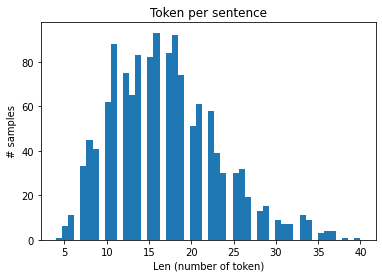

In [96]:
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [98]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

# print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
# print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  Bacterial infection is the major cause of persistent periapical inflammation following root canal treatment
Raw Label:  c c o o o o o e e e o o o o
After processing, sample: [1574 1872 1659 2978 2560 3447 1913  238 3751 1661 2595 1468 1482 3332
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
After processing, labels: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]


In [99]:
# !pip install keras_contrib

In [100]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from keras_contrib.layers import CRF


In [101]:
# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)


out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/dentme/anaconda3/envs/py365/lib/python3.6/site-packages/ipykernel/__main__.py:322: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
/home/dentme/anaconda3/envs/py365/lib/python3.6/site-packages/ipykernel/__main__.py:329: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            76140     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 4)             228       
Total params: 109,818
Trainable params: 109,818
Non-trainable params: 0
_________________________________________________________________


In [102]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)


Instructions for updating:
Use tf.cast instead.
Train on 1084 samples, validate on 121 samples
Epoch 1/5
 - 3s - loss: 6.8206 - crf_viterbi_accuracy: 0.3797 - val_loss: 6.8218 - val_crf_viterbi_accuracy: 0.4322
Epoch 2/5
 - 2s - loss: 6.6146 - crf_viterbi_accuracy: 0.4848 - val_loss: 6.7106 - val_crf_viterbi_accuracy: 0.5102
Epoch 3/5
 - 2s - loss: 6.4800 - crf_viterbi_accuracy: 0.5748 - val_loss: 6.5854 - val_crf_viterbi_accuracy: 0.5702
Epoch 4/5
 - 2s - loss: 6.3574 - crf_viterbi_accuracy: 0.6314 - val_loss: 6.5381 - val_crf_viterbi_accuracy: 0.6223
Epoch 5/5
 - 2s - loss: 6.2625 - crf_viterbi_accuracy: 0.6733 - val_loss: 6.4797 - val_crf_viterbi_accuracy: 0.6182


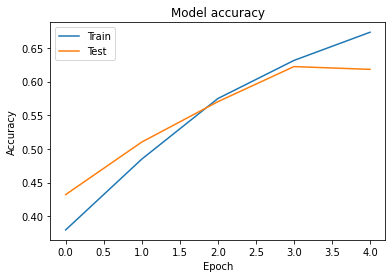

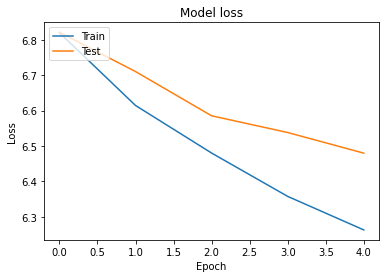

In [103]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [104]:

# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [107]:
# !pip install sklearn_crfsuite

In [108]:
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00      7754
           c       0.77      0.80      0.79       894
           e       0.61      0.37      0.46       524
           o       0.54      0.64      0.59       878

    accuracy                           0.92     10050
   macro avg       0.73      0.70      0.71     10050
weighted avg       0.92      0.92      0.92     10050



/home/dentme/anaconda3/envs/py365/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [120]:
# pred_tag
count = 0 
correct = 0
correct_c = 0
count_c = 0
correct_e = 0
count_e = 0
for pred,true in zip(pred_tag, y_te_true_tag):
#     print(pred, true)
    for a,b in zip(pred, true):
        if a != 'PAD' or b !='PAD':
            count+=1
            if a == b:
                correct+=1
                if a == 'c':
                    correct_c +=1
                elif a == 'e':
                    correct_e +=1
        if b == 'c':
            count_c+=1
        elif b == 'e':
            count_e +=1
    

In [122]:
print('acc' ,correct/count)

acc 0.6428571428571429


In [ ]:
print('precision c')

In [127]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 121 of 134 (Test Set)
Word           ||True ||Pred
The            : c     c
lack           : c     c
of             : c     c
attention      : c     c
to             : c     c
the            : c     c
three          : c     c
dimensional    : c     c
anatomy        : c     c
of             : c     c
the            : c     c
site           : c     c
of             : c     c
implant        : c     c
placement      : c     c
and            : c     c
the            : o     c
orientation    : o     c
of             : o     c
neighboring    : o     c
teeth          : o     c
may            : o     o
lead           : o     o
to             : o     o
the            : e     o
implant        : e     o
perforating    : e     o
the            : e     o
root           : e     o
and            : e     o
devitalizing   : e     o
the            : e     o
pulp           : e     o
